This is to test TTS models with benchmark sentences for speech synthesis.

Before running this script please DON'T FORGET: 
- to set file paths.
- to download related model files from TTS and WaveRNN.
- to checkout right commit versions (given next to the model) of TTS and WaveRNN.
- to set the right paths in the cell below.

Repositories:
- TTS: https://github.com/mozilla/TTS
- WaveRNN: https://github.com/erogol/WaveRNN

In [3]:
TTS_PATH = "/Users/thomas/workspace/ptf/faaake"
WAVERNN_PATH = "/Users/thomas/workspace/ptf"

In [16]:
%load_ext autoreload
%autoreload 2
import os
import sys
import io
import torch 
import time
import numpy as np
from collections import OrderedDict
from matplotlib import pylab as plt

%pylab inline
rcParams["figure.figsize"] = (16,5)

# add libraries into environment
sys.path.append(TTS_PATH) # set this if TTS is not installed globally
sys.path.append(WAVERNN_PATH) # set this if TTS is not installed globally

import librosa
import librosa.display

from TTS.models.tacotron import Tacotron 
from TTS.layers import *
from TTS.utils.data import *
from TTS.utils.audio import AudioProcessor
from TTS.utils.generic_utils import load_config, setup_model
from TTS.utils.text import text_to_sequence
from TTS.utils.synthesis import synthesis
from TTS.utils.visual import visualize

import IPython
from IPython.display import Audio


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Populating the interactive namespace from numpy and matplotlib


/Users/thomas/miniconda2/envs/mztts/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['plt']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [12]:
def tts(model, text, speaker_id, CONFIG, use_cuda, ap, use_gl, figures=True):
    t_1 = time.time()
    waveform, alignment, mel_spec, mel_postnet_spec, stop_tokens = synthesis(model, text, speaker_id, CONFIG, use_cuda, ap, False, CONFIG.enable_eos_bos_chars)
    if not use_gl:
        waveform = wavernn.generate(torch.FloatTensor(mel_postnet_spec.T).unsqueeze(0).cuda(), batched=batched_wavernn, target=11000, overlap=550)

    print(" >  Run-time: {}".format(time.time() - t_1))
    if figures:                                                                                                         
        visualize(alignment, mel_postnet_spec, stop_tokens, text, ap.hop_length, CONFIG, mel_spec)                                                                       
    IPython.display.display(Audio(waveform, rate=CONFIG.audio['sample_rate']))  
    os.makedirs(OUT_FOLDER, exist_ok=True)
    file_name = text.replace(" ", "_").replace(".","") + ".wav"
    out_path = os.path.join(OUT_FOLDER, file_name)
    ap.save_wav(waveform, out_path)
    return alignment, mel_postnet_spec, stop_tokens, waveform

In [9]:
# Set constants
ROOT_PATH = '/Users/thomas/workspace/playground/tc1'
MODEL_PATH = ROOT_PATH + '/best_model.pth.tar'
CONFIG_PATH = ROOT_PATH + '/config.json'
OUT_FOLDER = '/Users/thomas/workspace/playground/tc1/out'
CONFIG = load_config(CONFIG_PATH)
VOCODER_MODEL_PATH = ROOT_PATH + "/mold_ljspeech_best_model/checkpoint_433000.pth.tar"
VOCODER_CONFIG_PATH = ROOT_PATH + "/mold_ljspeech_best_model/config.json"
VOCODER_CONFIG = load_config(VOCODER_CONFIG_PATH)
use_cuda = False
CONFIG.windowing = True
use_gl = True    # use GL if True
batched_wavernn = True    # use batched wavernn inference if True

In [7]:
# LOAD TTS MODEL
from utils.text.symbols import symbols, phonemes

# load the model
num_chars = len(phonemes) if CONFIG.use_phonemes else len(symbols)
model = setup_model(num_chars, CONFIG)

# load the audio processor
ap = AudioProcessor(**CONFIG.audio)         


# load model state
if use_cuda:
    cp = torch.load(MODEL_PATH)
else:
    cp = torch.load(MODEL_PATH, map_location=lambda storage, loc: storage)

# load the model
model.load_state_dict(cp['model'])
if use_cuda:
    model.cuda()
model.eval()
print(cp['step'])

 > Using model: Tacotron
 > Setting up Audio Processor...
 | > bits:None
 | > sample_rate:22050
 | > num_mels:80
 | > min_level_db:-100
 | > frame_shift_ms:12.5
 | > frame_length_ms:50
 | > ref_level_db:20
 | > num_freq:1025
 | > power:1.5
 | > preemphasis:0.98
 | > griffin_lim_iters:60
 | > signal_norm:True
 | > symmetric_norm:False
 | > mel_fmin:0.0
 | > mel_fmax:8000.0
 | > max_norm:1.0
 | > clip_norm:True
 | > do_trim_silence:True
 | > n_fft:2048
 | > hop_length:275
 | > win_length:1102
412542


In [10]:
# LOAD WAVERNN
if use_gl == False:
    from WaveRNN.models.wavernn import Model
    bits = 10

    wavernn = Model(
            rnn_dims=512,
            fc_dims=512,
            mode="mold",
            pad=2,
            upsample_factors=VOCODER_CONFIG.upsample_factors,  # set this depending on dataset
            feat_dims=VOCODER_CONFIG.audio["num_mels"],
            compute_dims=128,
            res_out_dims=128,
            res_blocks=10,
            hop_length=ap.hop_length,
            sample_rate=ap.sample_rate,
        ).cuda()


    check = torch.load(VOCODER_MODEL_PATH)
    wavernn.load_state_dict(check['model'])
    if use_cuda:
        wavernn.cuda()
    wavernn.eval();

### Comparision with https://mycroft.ai/blog/available-voices/

/Users/thomas/miniconda2/envs/mztts/lib/python3.6/site-packages/librosa/util/utils.py:1725: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if np.issubdtype(x.dtype, float) or np.issubdtype(x.dtype, complex):


 >  Run-time: 3.772805690765381


/Users/thomas/miniconda2/envs/mztts/lib/python3.6/site-packages/librosa/display.py:656: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  if np.issubdtype(data.dtype, np.complex):


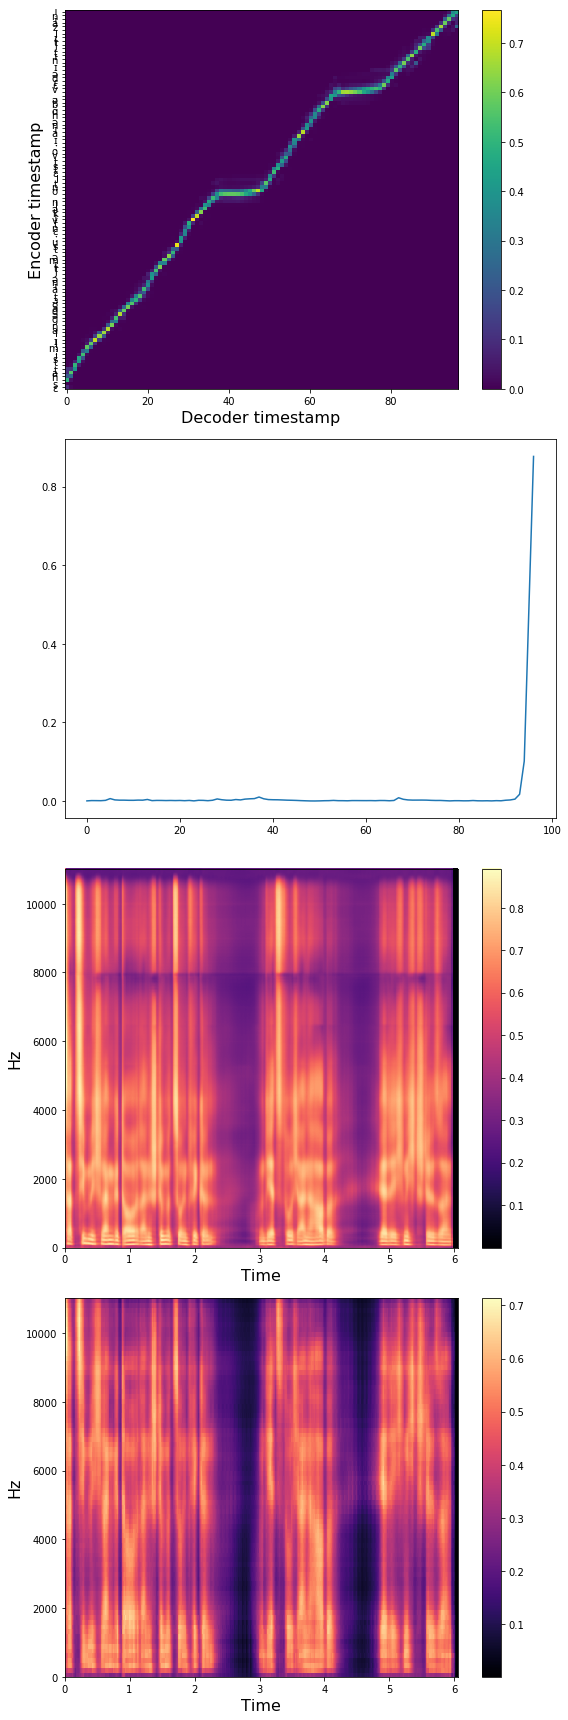

In [41]:
model.eval()
model.decoder.max_decoder_steps = 2000
sentence =  "Es hat ziemlich lang gedauert eine Stimme zu entwickeln, und jetzt wo ich eine habe, werde ich nicht still sein!"
align, spec, stop_tokens, wav = tts(model, sentence, , CONFIG, use_cuda, ap, use_gl=use_gl, figures=True)

/Users/thomas/miniconda2/envs/mztts/lib/python3.6/site-packages/librosa/util/utils.py:1725: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if np.issubdtype(x.dtype, float) or np.issubdtype(x.dtype, complex):


 >  Run-time: 3.383554697036743


/Users/thomas/miniconda2/envs/mztts/lib/python3.6/site-packages/librosa/display.py:656: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  if np.issubdtype(data.dtype, np.complex):


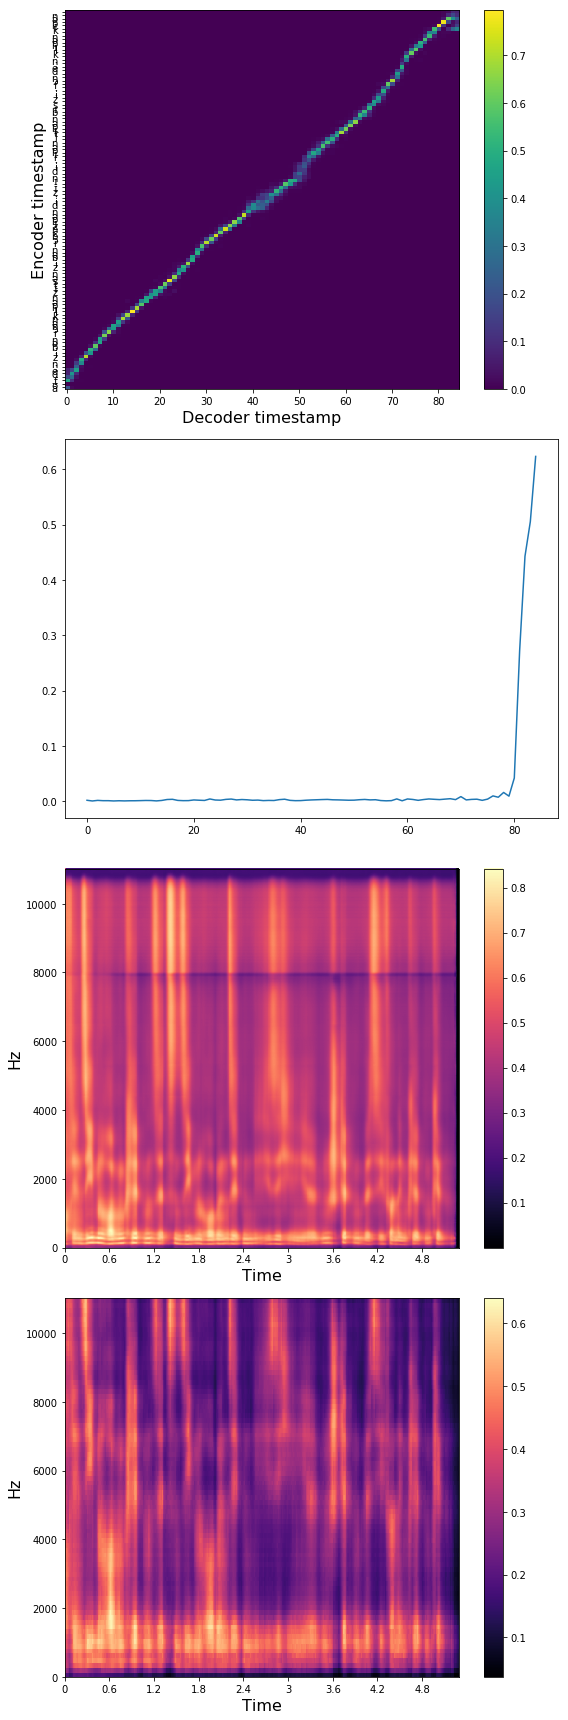

In [59]:
sentence = "Auf den sieben Robbenklippen sitzen sieben Robbensippen die sich in die Rippen stippen bis sie von den Klippen kippen."  # 'echo' is not in training set. 
align, spec, stop_tokens, wav = tts(model, sentence, 120, CONFIG, use_cuda, ap, use_gl=use_gl, figures=True)

In [ ]:
sentence = "The human voice is the most perfect instrument of all."
align, spec, stop_tokens, wav = tts(model, sentence, CONFIG, use_cuda, ap, use_gl=use_gl, figures=True)

In [ ]:
sentence = "I'm sorry Dave. I'm afraid I can't do that."
align, spec, stop_tokens, wav = tts(model, sentence, CONFIG, use_cuda, ap, use_gl=use_gl, figures=True)

In [ ]:
sentence = "This cake is great. It's so delicious and moist ."
align, spec, stop_tokens, wav = tts(model, sentence, CONFIG, use_cuda, ap, use_gl=use_gl, figures=True)

In [ ]:
sentence = "This cake is great. It's so delicious and moist."
align, spec, stop_tokens, wav = tts(model, sentence, CONFIG, use_cuda, ap, use_gl=use_gl, figures=True)

### Comparison with https://keithito.github.io/audio-samples/

In [ ]:
sentence = "Generative adversarial network or variational auto-encoder."
align, spec, stop_tokens, wav = tts(model, sentence, CONFIG, use_cuda, ap, use_gl=use_gl, figures=True)

In [ ]:
sentence = "Scientists at the CERN laboratory say they have discovered a new particle."
align, spec, stop_tokens, wav = tts(model, sentence, CONFIG, use_cuda, ap, use_gl=use_gl, figures=True)

In [ ]:
sentence = "Here’s a way to measure the acute emotional intelligence that has never gone out of style."
align, spec, stop_tokens, wav = tts(model, sentence, CONFIG, use_cuda, ap, use_gl=use_gl, figures=True)

In [ ]:
sentence = "President Trump met with other leaders at the Group of 20 conference."
align, spec, stop_tokens, wav = tts(model, sentence, CONFIG, use_cuda, ap, use_gl=use_gl, figures=True)

In [ ]:
sentence = "The buses aren't the problem, they actually provide a solution."
align, spec, stop_tokens, wav = tts(model, sentence, CONFIG, use_cuda, ap, use_gl=use_gl, figures=True)

### Comparison with https://google.github.io/tacotron/publications/tacotron/index.html

In [ ]:
sentence = "Generative adversarial network or variational auto-encoder."
align, spec, stop_tokens, wav = tts(model, sentence, CONFIG, use_cuda, ap, use_gl=use_gl, figures=True)

In [ ]:
sentence = "Basilar membrane and otolaryngology are not auto-correlations."
align, spec, stop_tokens, wav = tts(model, sentence, CONFIG, use_cuda, ap, use_gl=use_gl, figures=True)

In [ ]:
sentence = " He has read the whole thing."
align, spec, stop_tokens, wav = tts(model, sentence, CONFIG, use_cuda, ap, use_gl=use_gl, figures=True)

In [ ]:
sentence = "He reads books."
align, spec, stop_tokens, wav = tts(model, sentence, CONFIG, use_cuda, ap, use_gl=use_gl, figures=True)

In [ ]:
sentence = "Thisss isrealy awhsome."
align, spec, stop_tokens, wav = tts(model, sentence, CONFIG, use_cuda, ap, use_gl=use_gl, figures=True)

In [ ]:
sentence = "This is your internet browser, Firefox."
align, spec, stop_tokens, wav = tts(model, sentence, CONFIG, use_cuda, ap, use_gl=use_gl, figures=True)

In [ ]:
sentence = "This is your internet browser Firefox."
align, spec, stop_tokens, wav = tts(model, sentence, CONFIG, use_cuda, ap, use_gl=use_gl, figures=True)

In [ ]:
sentence = "The quick brown fox jumps over the lazy dog."
align, spec, stop_tokens, wav = tts(model, sentence, CONFIG, use_cuda, ap, use_gl=use_gl, figures=True)

In [ ]:
sentence = "Does the quick brown fox jump over the lazy dog?"
align, spec, stop_tokens, wav = tts(model, sentence, CONFIG, use_cuda, ap, use_gl=use_gl, figures=True)

In [ ]:
sentence = "Eren, how are you?"
align, spec, stop_tokens, wav = tts(model, sentence, CONFIG, use_cuda, ap, use_gl=use_gl, figures=True)

### Hard Sentences

In [ ]:
sentence = "Encouraged, he started with a minute a day."
align, spec, stop_tokens, wav = tts(model, sentence, CONFIG, use_cuda, ap, use_gl=use_gl, figures=True)

In [ ]:
sentence = "His meditation consisted of “body scanning” which involved focusing his mind and energy on each section of the body from head to toe ."
align, spec, stop_tokens, wav = tts(model, sentence, CONFIG, use_cuda, ap, use_gl=use_gl, figures=True)

In [ ]:
sentence = "Recent research at Harvard has shown meditating for as little as 8 weeks can actually increase the grey matter in the parts of the brain responsible for emotional regulation and learning . "
align, spec, stop_tokens, wav = tts(model, sentence, CONFIG, use_cuda, ap, use_gl=use_gl, figures=True)

In [ ]:
sentence = "If he decided to watch TV he really watched it."
align, spec, stop_tokens, wav = tts(model, sentence, CONFIG, use_cuda, ap, use_gl=use_gl, figures=True)

In [ ]:
sentence = "Often we try to bring about change through sheer effort and we put all of our energy into a new initiative ."
align, spec, stop_tokens, wav = tts(model, sentence, CONFIG, use_cuda, ap, use_gl=use_gl, figures=True)

In [ ]:
# for twb dataset
sentence = "In our preparation for Easter, God in his providence offers us each year the season of Lent as a “sacramental sign of our conversion."
align, spec, stop_tokens, wav = tts(model, sentence, CONFIG, use_cuda, ap, use_gl=use_gl, figures=True)

In [ ]:
# !zip benchmark_samples/samples.zip benchmark_samples/*